In [1]:
import os
import numpy as np
import librosa
import soundfile as sf
import ddsp
import ddsp.training
from ddsp.training import metrics
import gin
from IPython.display import Audio
import pickle
from ddsp.effects import Reverb
import tensorflow.compat.v2 as tf
from ddsp.training.postprocessing import (
    detect_notes, fit_quantile_transform
)
from IPython.display import Audio
import sounddevice as sd
from scipy.io.wavfile import write

2025-02-04 14:09:43.117673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 14:09:43.233721: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-04 14:09:43.233752: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-04 14:09:43.990852: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-

In [2]:
# # Set recording parameters
# duration = 10  # Duration in seconds
# sample_rate = 16000  # Sample rate in Hz

# # Record audio
# print("Recording...")
# audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
# sd.wait()  # Wait until recording is finished
# print("Recording complete.")

# # Save the recorded audio to a file
# write("my_recording.wav", sample_rate, audio_data)
# print("Audio saved to 'my_recording.wav'.")

# # Play the recorded audio
# Audio("my_recording.wav")

Recording...
Recording complete.
Audio saved to 'my_recording.wav'.


In [57]:
# DATASET_STATS = None
ADJUST = True  # Flag for automatic adjustment
quiet = 30  # Quiet parts without notes detected (dB)
threshold = 0.8  # Threshold for note detection
pitch_shift = 0  # Manual pitch shift (in octaves)
loudness_shift = -20  # Manual loudness shift (in dB)
autotune = 0.2
# audio_features_mod = None
# mask_on = None

In [68]:
input_audio_path = r"/home/inazuma/Desktop/Working/Tune/test/voice4.wav"
# input_audio_path = r"/home/inazuma/my_recording.wav"
# output_audio_path = r"/home/inazuma/Desktop/Working/Tune/test/test3_output.wav"
model_path = r"/home/inazuma/Desktop/Working/Tune/model/"
dataset_stats_file = r"/home/inazuma/Desktop/Working/Tune/dataset_statistics.pkl"
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))
print(DATASET_STATS)
audio, sr = librosa.load(input_audio_path, sr=16000)
print(f"Audio shape: {audio.shape}")
print(f"Sample rate: {sr}")

Audio(audio, rate=16000)

{'mean_pitch': 570.4347841366474, 'quantile_transform': QuantileTransformer(), 'loudness_db': array([ -90.04965,  -90.04965,  -90.04965, ..., -100.     , -100.     ,
       -100.     ], dtype=float32)}
Audio shape: (180800,)
Sample rate: 16000


In [69]:
audio_gen,audio_features,model = process_audio(audio, model_path)
Audio(audio_gen, rate=16000)

/home/inazuma/miniconda3/envs/tune/lib/python3.10/site-packages/crepe/core.py:209: RuntimeWarning: invalid value encountered in divide
  frames /= np.std(frames, axis=1)[:, np.newaxis]
/home/inazuma/miniconda3/envs/tune/lib/python3.10/site-packages/librosa/core/convert.py:1870: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


In [73]:
quiet = 40  # Quiet parts without notes detected (dB) 0 - 60 db
threshold = 0.8  # Threshold for note detection range 0.00-2.00
pitch_shift = -0.5  # Manual pitch shift (in octaves) -2.00 - 2.00
loudness_shift = -200  # Manual loudness shift (in dB) -20 - 20 db
autotune = 0.8 # 0 - 1
audio_gen_2,audio_features_mod = process_audio_features(audio_features, model, ADJUST, DATASET_STATS, threshold, quiet, autotune, loudness_shift, pitch_shift)
Audio(audio_gen_2,rate=16000)

{'audio': array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.7554797e-11, -8.3731667e-12, -6.0275333e-11]], dtype=float32), 'loudness_db': array([-880., -880., -880., ..., -880., -880., -880.], dtype=float32), 'f0_hz': array([   5.623075,    5.623075,    5.623075, ..., 1392.9823  ,
       1392.2881  , 1404.4911  ], dtype=float32), 'f0_confidence': array([0.        , 0.        , 0.        , ..., 0.14567743, 0.143908  ,
       0.07461251], dtype=float32)}


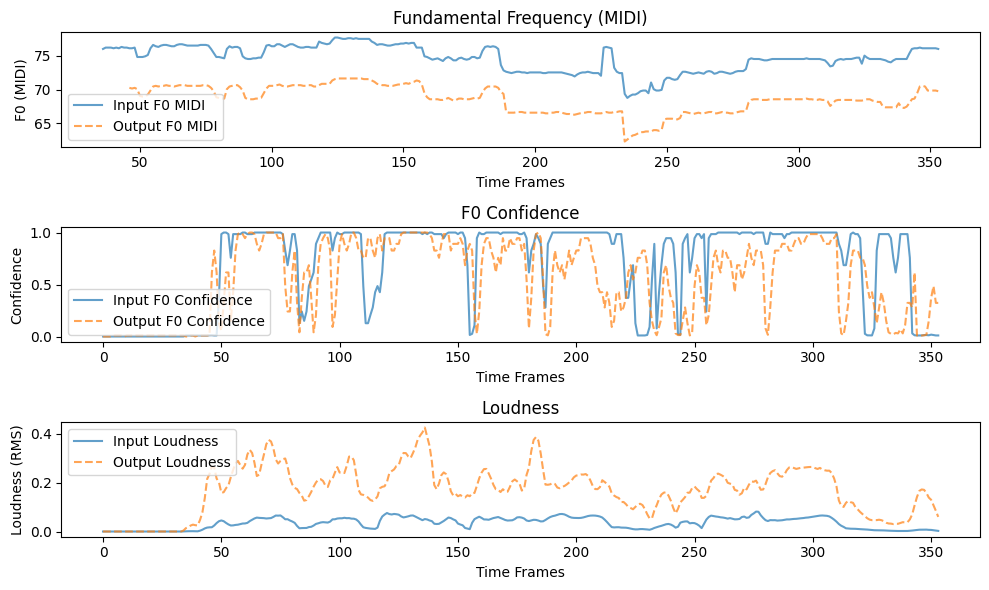

In [75]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_audio_features(input_audio, output_audio, sr=16000):
    # Load audio files
    y_in, _ = librosa.load(input_audio, sr=sr)
    y_out, _ = librosa.load(output_audio, sr=sr)

    # Extract pitch (F0) and confidence
    f0_in, voiced_flag_in, f0_confidence_in = librosa.pyin(y_in, fmin=50, fmax=1000)
    f0_out, voiced_flag_out, f0_confidence_out = librosa.pyin(y_out, fmin=50, fmax=1000)

    # Compute loudness
    S_in = librosa.feature.rms(y=y_in)
    S_out = librosa.feature.rms(y=y_out)

    # Convert F0 to MIDI
    f0_midi_in = librosa.hz_to_midi(f0_in)
    f0_midi_out = librosa.hz_to_midi(f0_out)

    # Plot F0 MIDI
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    plt.plot(f0_midi_in, label="Input F0 MIDI", alpha=0.7)
    plt.plot(f0_midi_out, label="Output F0 MIDI", alpha=0.7, linestyle="dashed")
    plt.xlabel("Time Frames")
    plt.ylabel("F0 (MIDI)")
    plt.legend()
    plt.title("Fundamental Frequency (MIDI)")

    # Plot F0 confidence
    plt.subplot(3, 1, 2)
    plt.plot(f0_confidence_in, label="Input F0 Confidence", alpha=0.7)
    plt.plot(f0_confidence_out, label="Output F0 Confidence", alpha=0.7, linestyle="dashed")
    plt.xlabel("Time Frames")
    plt.ylabel("Confidence")
    plt.legend()
    plt.title("F0 Confidence")

    # Plot Loudness
    plt.subplot(3, 1, 3)
    plt.plot(S_in[0], label="Input Loudness", alpha=0.7)
    plt.plot(S_out[0], label="Output Loudness", alpha=0.7, linestyle="dashed")
    plt.xlabel("Time Frames")
    plt.ylabel("Loudness (RMS)")
    plt.legend()
    plt.title("Loudness")

    plt.tight_layout()
    plt.show()

# Example usage
plot_audio_features(input_audio_path,"Downloads/test.wav")


In [65]:
def process_audio(audio, model_path):
    # Ensure audio is in the correct shape
    if len(audio.shape) == 1:
        audio = audio[np.newaxis, :]
    
    # Reset DDSP CREPE processing
    ddsp.spectral_ops.reset_crepe()
    
    # Compute audio features
    audio_features = metrics.compute_audio_features(audio)
    audio_features['loudness_db'] = audio_features['loudness_db'].numpy().astype(np.float32)
    
    # Load Model Configuration
    gin_file = os.path.join(model_path, 'operative_config-0.gin')
    with gin.unlock_config():
        gin.parse_config_file(gin_file, skip_unknown=True)
    
    # Ensure dimensions and sampling rates are correct
    time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
    n_samples_train = gin.query_parameter('Harmonic.n_samples')
    hop_size = int(n_samples_train / time_steps_train)
    time_steps = int(audio.shape[1] / hop_size)
    n_samples = time_steps * hop_size
    
    gin_params = [
        f'Harmonic.n_samples = {n_samples}',
        f'FilteredNoise.n_samples = {n_samples}',
        f'F0LoudnessPreprocessor.time_steps = {time_steps}',
        'oscillator_bank.use_angular_cumsum = True',
    ]
    
    with gin.unlock_config():
        gin.parse_config(gin_params)
    
    # Trim all input vectors to correct lengths
    for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
        audio_features[key] = audio_features[key][:time_steps]
    audio_features['audio'] = audio_features['audio'][:, :n_samples]
    
    # Load model
    model = ddsp.training.models.Autoencoder()
    model.restore(model_path)
    
    # Build model by running a batch through it
    _ = model(audio_features, training=False)
    
    # Generate audio
    audio_gen = model.get_audio_from_outputs(_)
    
    # Convert to NumPy array if it's a TensorFlow tensor
    if hasattr(audio_gen, 'numpy'):
        audio_gen = audio_gen.numpy()
    
    # Normalize audio to prevent clipping
    audio_gen = audio_gen / np.max(np.abs(audio_gen))
    
    return audio_gen,audio_features,model


## Helper functions.
def shift_ld(audio_features, ld_shift=-10.0):
    new_audio_features = audio_features.copy()  # Ensure it's a new dictionary
    new_audio_features['loudness_db'] += ld_shift
    return new_audio_features



def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features

def get_tuning_factor(f0_midi, f0_confidence, mask_on):
  """Get an offset in cents, to most consistent set of chromatic intervals."""
  # Difference from midi offset by different tuning_factors.
  tuning_factors = np.linspace(-0.5, 0.5, 101)  # 1 cent divisions.
  midi_diffs = (f0_midi[mask_on][:, np.newaxis] -
                tuning_factors[np.newaxis, :]) % 1.0
  midi_diffs[midi_diffs > 0.5] -= 1.0
  weights = f0_confidence[mask_on][:, np.newaxis]

  ## Computes mininmum adjustment distance.
  cost_diffs = np.abs(midi_diffs)
  cost_diffs = np.mean(weights * cost_diffs, axis=0)

  ## Computes mininmum "note" transitions.
  f0_at = f0_midi[mask_on][:, np.newaxis] - midi_diffs
  f0_at_diffs = np.diff(f0_at, axis=0)
  deltas = (f0_at_diffs != 0.0).astype(float)
  cost_deltas = np.mean(weights[:-1] * deltas, axis=0)

  # Tuning factor is minimum cost.
  norm = lambda x: (x - np.mean(x)) / np.std(x)
  cost = norm(cost_deltas) + norm(cost_diffs)
  return tuning_factors[np.argmin(cost)]


def get_tuning_factor_sarangi(f0_midi, f0_confidence, mask_on):
    """Get an offset in cents, tuned to the most consistent set of raga intervals."""
    # Define tuning factor range with finer granularity for microtonal accuracy
    tuning_factors = np.linspace(-0.5, 0.5, 201)  # 0.5 cent divisions
    
    # Difference from MIDI offset by different tuning_factors
    midi_diffs = (f0_midi[mask_on][:, np.newaxis] - tuning_factors[np.newaxis, :]) % 1.0
    midi_diffs[midi_diffs > 0.5] -= 1.0
    weights = f0_confidence[mask_on][:, np.newaxis]
    
    # Compute minimum adjustment distance with confidence weighting
    cost_diffs = np.abs(midi_diffs)
    cost_diffs = np.mean(weights * cost_diffs, axis=0)
    
    # Compute smoothness of transitions (avoiding abrupt note jumps)
    f0_at = f0_midi[mask_on][:, np.newaxis] - midi_diffs
    f0_at_diffs = np.diff(f0_at, axis=0)
    deltas = (np.abs(f0_at_diffs) > 0.01).astype(float)  # Allow microtonal continuity
    cost_deltas = np.mean(weights[:-1] * deltas, axis=0)
    
    # Normalize and find the optimal tuning factor
    norm = lambda x: (x - np.mean(x)) / np.std(x)
    cost = norm(cost_deltas) + norm(cost_diffs)
    return tuning_factors[np.argmin(cost)]

def auto_tune(f0_midi, tuning_factor, mask_on, amount=0.0, chromatic=False):
  """Reduce variance of f0 from the chromatic or scale intervals."""
  if chromatic:
    midi_diff = (f0_midi - tuning_factor) % 1.0
    midi_diff[midi_diff > 0.5] -= 1.0
  else:
    major_scale = np.ravel(
        [np.array([0, 2, 4, 5, 7, 9, 11]) + 12 * i for i in range(10)])
    all_scales = np.stack([major_scale + i for i in range(12)])

    f0_on = f0_midi[mask_on]
    # [time, scale, note]
    f0_diff_tsn = (
        f0_on[:, np.newaxis, np.newaxis] - all_scales[np.newaxis, :, :])
    # [time, scale]
    f0_diff_ts = np.min(np.abs(f0_diff_tsn), axis=-1)
    # [scale]
    f0_diff_s = np.mean(f0_diff_ts, axis=0)
    scale_idx = np.argmin(f0_diff_s)
    scale = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb',
             'G', 'Ab', 'A', 'Bb', 'B', 'C'][scale_idx]

    # [time]
    f0_diff_tn = f0_midi[:, np.newaxis] - all_scales[scale_idx][np.newaxis, :]
    note_idx = np.argmin(np.abs(f0_diff_tn), axis=-1)
    midi_diff = np.take_along_axis(
        f0_diff_tn, note_idx[:, np.newaxis], axis=-1)[:, 0]
    print('Autotuning... \nInferred key: {}  '
          '\nTuning offset: {} cents'.format(scale, int(tuning_factor * 100)))

  # Adjust the midi signal.
  return f0_midi - amount * midi_diff


def auto_tune_sarangi(f0_midi, tuning_factor, mask_on, amount=0.0, raga='Yaman'):
    """Adjust f0 to fit raga-specific swaras while preserving expressive slides."""
    raga_swaras_dict = {
        'Yaman': np.array([60, 62, 64, 66, 67, 69, 71]),  # Sa Re Ga Ma Pa Dha Ni
        'Bhairav': np.array([60, 61, 64, 65, 67, 68, 71]),  # Sa Komal Re Ga Ma Pa Komal Dha Ni
        'Bhairavi': np.array([60, 61, 63, 65, 67, 68, 70]),  # Sa Komal Re Komal Ga Ma Pa Komal Dha Komal Ni
        'Kafi': np.array([60, 62, 63, 65, 67, 69, 70]),  # Sa Re Komal Ga Ma Pa Dha Komal Ni
        'Todi': np.array([60, 61, 63, 66, 67, 68, 71])  # Sa Komal Re Komal Ga Teevra Ma Pa Komal Dha Ni
    }
    
    if raga not in raga_swaras_dict:
        raise ValueError(f"Raga '{raga}' not found. Available ragas: {list(raga_swaras_dict.keys())}")
    
    raga_swaras = raga_swaras_dict[raga]
    
    f0_on = f0_midi[mask_on]
    
    # Compute pitch difference from each swara
    f0_diff_tn = f0_midi[:, np.newaxis] - raga_swaras[np.newaxis, :]
    
    # Find nearest swara for each time step
    note_idx = np.argmin(np.abs(f0_diff_tn), axis=-1)
    midi_diff = np.take_along_axis(f0_diff_tn, note_idx[:, np.newaxis], axis=-1)[:, 0]
    
    # Weighted adjustment to preserve microtonal nuance
    adjusted_f0 = f0_midi - amount * midi_diff * tuning_factor  
    
    return adjusted_f0


def process_audio_features(audio_features, model, ADJUST, DATASET_STATS, threshold, quiet, autotune, loudness_shift, pitch_shift):
    """
    Process audio features with optional loudness adjustment, auto-tuning, and pitch shifting.

    Parameters:
    - audio_features: dict, containing 'loudness_db', 'f0_confidence', 'f0_hz'.
    - model: the DDSP model used for generating audio.
    - ADJUST: bool, whether to adjust loudness and tuning.
    - DATASET_STATS: dict or None, containing dataset statistics for normalization.
    - threshold: float, threshold for detecting notes.
    - quiet: float, factor to reduce loudness when notes are off.
    - autotune: float, amount of auto-tuning.
    - loudness_shift: float, amount of loudness shift.
    - pitch_shift: float, amount of pitch shift.
    
    Returns:
    - audio_gen: NumPy array, the generated audio signal.
    """
    audio_features_mod = audio_features.copy()
    
    if ADJUST and DATASET_STATS is not None:
        mask_on, note_on_value = detect_notes(audio_features['loudness_db'],
                                              audio_features['f0_confidence'],
                                              threshold)
        
        if np.any(mask_on):
            # _, loudness_norm = fit_quantile_transform(
            #     audio_features['loudness_db'],
            #     mask_on,
            #     inv_quantile=DATASET_STATS['quantile_transform']
            # )
            
            # mask_off = np.logical_not(mask_on)
            # loudness_norm[mask_off] -= quiet * (1.0 - note_on_value[mask_off][:, np.newaxis])
            # loudness_norm = np.reshape(loudness_norm, audio_features['loudness_db'].shape)
            
            # audio_features_mod['loudness_db'] = loudness_norm
            
            if autotune:
                f0_midi = np.array(ddsp.core.hz_to_midi(audio_features_mod['f0_hz']))
                tuning_factor = get_tuning_factor_sarangi(f0_midi, audio_features_mod['f0_confidence'], mask_on)
                f0_midi_at = auto_tune_sarangi(f0_midi, tuning_factor, mask_on, amount=autotune)
                audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)
    else:
        print('\nSkipping auto-adjust (box not checked or no dataset statistics found).')
    
    audio_features_mod = shift_ld(audio_features_mod, loudness_shift)
    audio_features_mod = shift_f0(audio_features_mod, pitch_shift)
    print(audio_features_mod)
    
    outputs = model(audio_features_mod, training=False)
    audio_gen = model.get_audio_from_outputs(outputs)
    
    if hasattr(audio_gen, 'numpy'):
        audio_gen = audio_gen.numpy()
    
    audio_gen = audio_gen / np.max(np.abs(audio_gen))  # Normalize to prevent clipping
    
    return audio_gen,audio_features_mod


/home/inazuma/miniconda3/envs/tune/lib/python3.10/site-packages/librosa/core/convert.py:1870: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


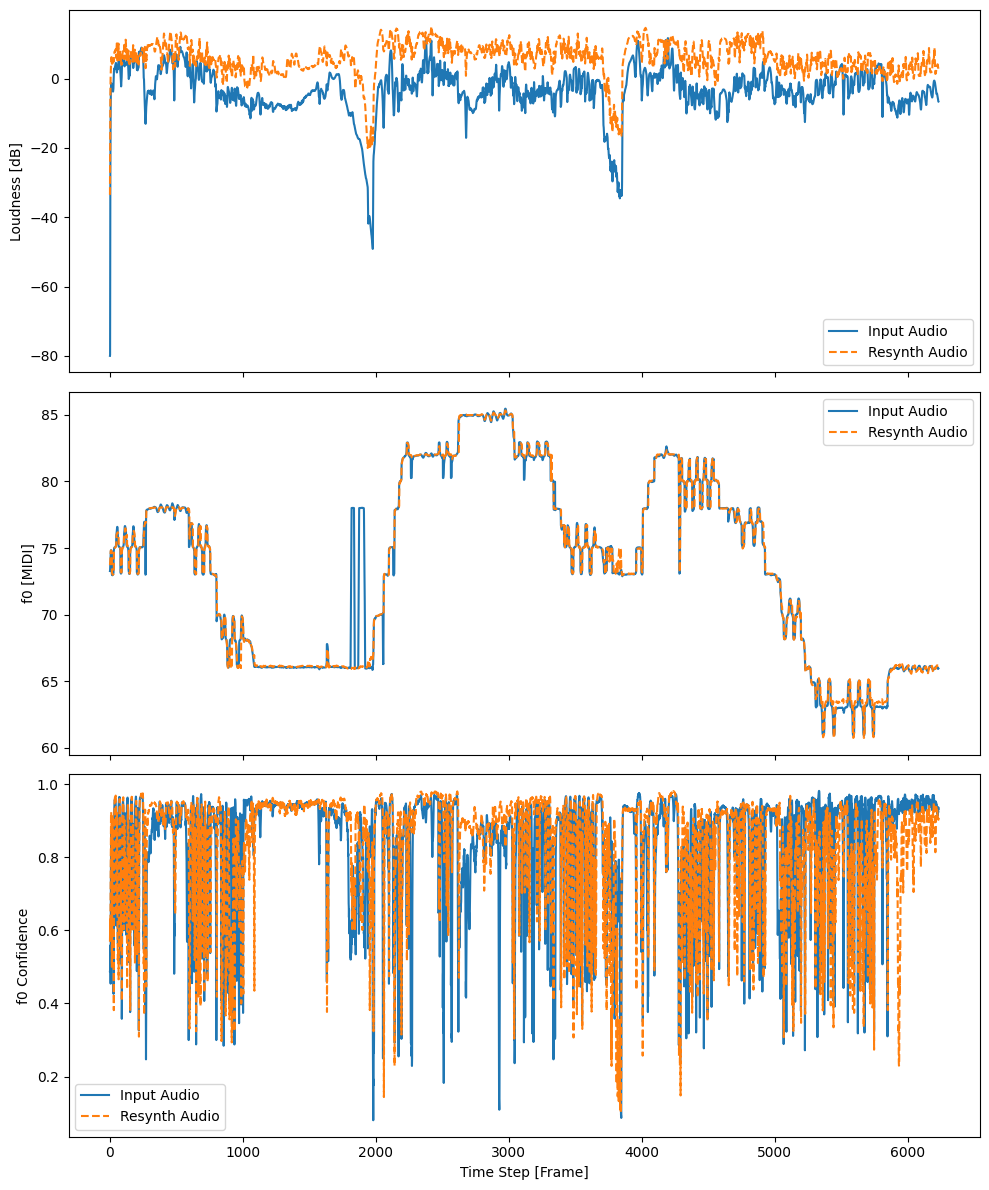

In [90]:
# import matplotlib.p
# Define the trim value
TRIM = -15

# Process the input audio features
input_loudness_db = audio_features['loudness_db'][:TRIM]
input_f0_hz = librosa.hz_to_midi(audio_features['f0_hz'][:TRIM])
input_f0_confidence = audio_features['f0_confidence'][:TRIM]

# Process the resynthesized audio features
resynth_audio_features = metrics.compute_audio_features(audio_gen)
resynth_audio_features['loudness_db'] = resynth_audio_features['loudness_db'].numpy().astype(np.float32)

resynth_loudness_db = resynth_audio_features['loudness_db'][:TRIM]
resynth_f0_hz = librosa.hz_to_midi(resynth_audio_features['f0_hz'][:TRIM])
resynth_f0_confidence = resynth_audio_features['f0_confidence'][:TRIM]

# resynth_loudness_db = audio_features_mod['loudness_db'][:TRIM]
# resynth_f0_hz = librosa.hz_to_midi(audio_features_mod['f0_hz'][:TRIM])
# resynth_f0_confidence = audio_features_mod['f0_confidence'][:TRIM]

# Plot features for both input and resynthesized audio
fig, ax = plt.subplots(nrows=3,
                       ncols=1,
                       sharex=True,
                       figsize=(10, 12))

# Plot loudness
ax[0].plot(input_loudness_db, label="Input Audio")
ax[0].plot(resynth_loudness_db, label="Resynth Audio", linestyle='--')
ax[0].set_ylabel('Loudness [dB]')
ax[0].legend()

# Plot f0 in MIDI
ax[1].plot(input_f0_hz, label="Input Audio")
ax[1].plot(resynth_f0_hz, label="Resynth Audio", linestyle='--')
ax[1].set_ylabel('f0 [MIDI]')
ax[1].legend()

# Plot f0 confidence
ax[2].plot(input_f0_confidence, label="Input Audio")
ax[2].plot(resynth_f0_confidence, label="Resynth Audio", linestyle='--')
ax[2].set_ylabel('f0 Confidence')
ax[2].set_xlabel('Time Step [Frame]')
ax[2].legend()

plt.tight_layout()
plt.savefig("sine_wave_highres1.png", dpi=300, format="png")
plt.show()

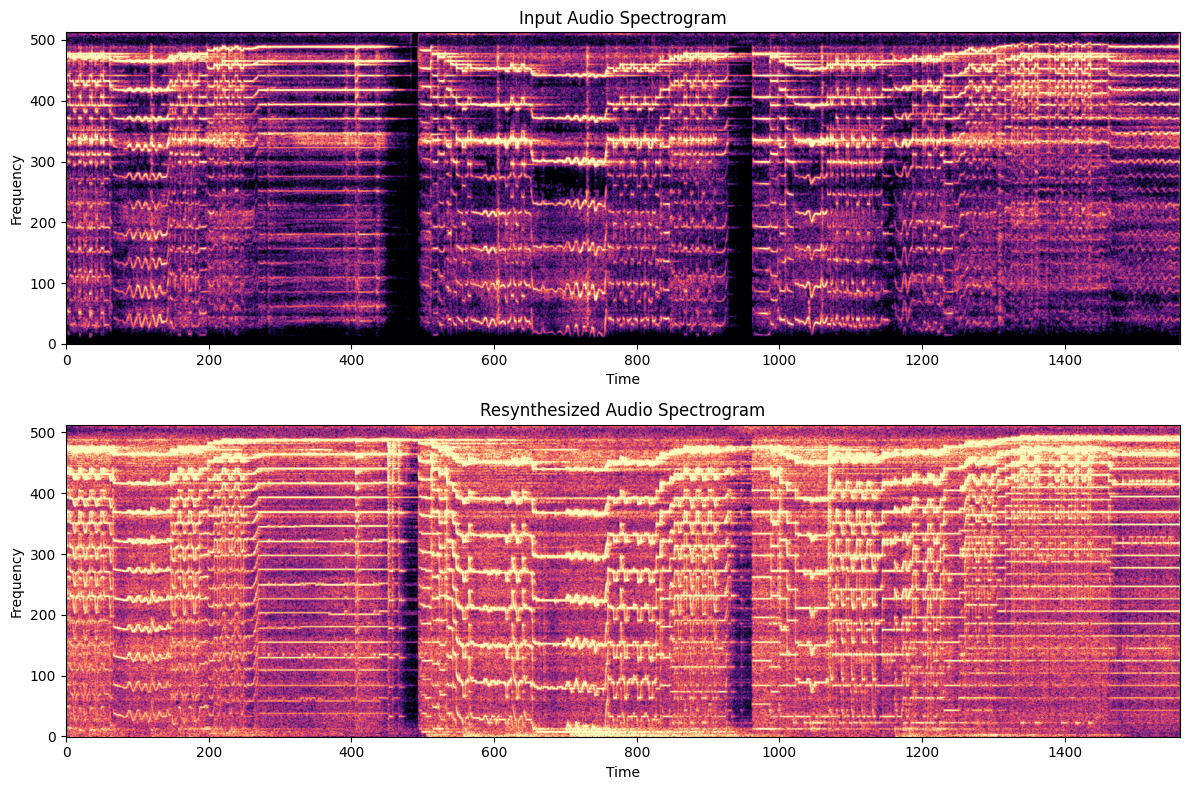

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import ddsp

# Compute log magnitude spectrogram
def compute_logmag_spectrogram(audio, size=768):
    """Compute log magnitude spectrogram of audio."""
    if len(audio.shape) == 2:  # If batched, take the first element
        audio = audio[0]
    logmag = ddsp.spectral_ops.compute_logmag(ddsp.core.tf_float32(audio), size=size)
    return logmag.numpy() if hasattr(logmag, 'numpy') else logmag

# Compute spectrograms for input and resynthesized audio
input_spectrogram = compute_logmag_spectrogram(audio_features['audio'], size=1024)
resynth_spectrogram = compute_logmag_spectrogram(audio_gen_2, size=1024)

# Rotate spectrograms for better visualization
input_spectrogram = np.rot90(input_spectrogram)
resynth_spectrogram = np.rot90(resynth_spectrogram)

# Plot the spectrograms
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Input audio spectrogram
ax[0].imshow(input_spectrogram, aspect='auto', origin='lower', cmap='magma', vmin=-5, vmax=1)
ax[0].set_title("Input Audio Spectrogram")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Frequency")

# Resynthesized audio spectrogram
ax[1].imshow(resynth_spectrogram, aspect='auto', origin='lower', cmap='magma', vmin=-5, vmax=1)
ax[1].set_title("Resynthesized Audio Spectrogram")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.savefig("melspectogram.png", dpi=300, format="png")
plt.show()

In [135]:
import tensorflow as tf
from ddsp.effects import Reverb
import numpy as np
from IPython.display import Audio

# Assuming `audio_gen` is your generated audio array
# Convert audio to TensorFlow tensor
audio_gen = tf.convert_to_tensor(audio_gen_2, dtype=tf.float32)

# Define an impulse response (IR)
ir_length = 5000  # Length of the impulse response
ir = np.random.normal(0, 0.01, size=(ir_length,))  # Small random noise IR
ir = tf.convert_to_tensor(ir, dtype=tf.float32)

# Ensure audio_gen and ir are 2D
if len(audio_gen_2.shape) == 1:
    audio_gen_2 = audio_gen_2[tf.newaxis, :]  # Add batch dimension

if len(ir.shape) == 1:
    ir = ir[tf.newaxis, :]  # Add batch dimension

# Create an instance of the Reverb class
reverb_effect = Reverb(trainable=False, reverb_length=ir_length, add_dry=True)

# Process the audio with the reverb effect
reverb_controls = reverb_effect.get_controls(audio_gen_2, ir)
audio_with_reverb = reverb_effect.get_signal(**reverb_controls)

# Convert TensorFlow tensor back to NumPy array
audio_with_reverb = audio_with_reverb.numpy().flatten()

# Normalize the audio (optional)
audio_with_reverb = audio_with_reverb / np.max(np.abs(audio_with_reverb))


# Play the audio with reverb
Audio(audio_with_reverb, rate=16000)  # Replace 16000 with your sample rate


In [136]:
 # Match lengths
audio_with_reverb*=0.15
audio_combined = audio + audio_with_reverb  # Combine signals

# Normalize to prevent clipping
audio_combined = audio_combined / np.max(np.abs(audio_combined))

# Play the combined audio
Audio(audio_combined, rate=16000)

In [56]:
# audio_features_mod = {k: v.copy() for k, v in audio_features.items()}
# print(audio_features_mod)

# def improved_pitch_shift_sarangi(audio_features, target_mean_pitch):
#     # More sarangi-specific pitch shifting
#     pitch = ddsp.core.hz_to_midi(audio_features['f0_hz'])
    
#     # Use robust median for pitch estimation
#     mean_pitch = np.median(pitch[mask_on])
    
#     # Wider pitch shift range typical for sarangi
#     p_diff = np.clip(target_mean_pitch - mean_pitch, -12, 12)
    
#     # More nuanced octave conversion
#     p_diff_octave = np.round(p_diff / 12.0, decimals=1)
    
#     return shift_f0(audio_features, p_diff_octave)

# def detect_notes_sarangi(loudness_db, f0_confidence, threshold=0.8):
#     # More sensitive note detection for sarangi
#     note_on = (loudness_db > np.percentile(loudness_db, 30)) & \
#               (f0_confidence > threshold)
    
#     # Consider sarangi's unique dynamics
#     note_on_value = np.where(note_on, 
#                               np.clip(f0_confidence, 0, 1), 
#                               0)
    
#     return note_on, note_on_value

# def fit_quantile_transform_sarangi(loudness_db, mask_on, quantile_transformer):
#     # More robust loudness normalization
#     # Consider sarangi's dynamic range
    
#     # If mask_on is boolean, convert to indices
#     if mask_on.dtype == bool:
#         mask_indices = np.where(mask_on)[0]
#     else:
#         mask_indices = mask_on
    
#     # Extract loudness values for note-on regions
#     loudness_note_on = loudness_db[mask_on]
    
#     # Use the existing quantile transformer to transform
#     loudness_norm = np.copy(loudness_db)
    
#     # If it's a QuantileTransformer from scikit-learn
#     if hasattr(quantile_transformer, 'transform'):
#         # Transform only the note-on regions
#         transformed_loudness = quantile_transformer.transform(
#             loudness_note_on.reshape(-1, 1)
#         ).flatten()
        
#         # Put transformed values back into the original array
#         loudness_norm[mask_on] = transformed_loudness
#     else:
#         # Fallback to numpy quantile if it's a numeric value
#         quantile_transform = np.quantile(loudness_note_on, quantile_transformer)
#         loudness_norm[mask_on] = quantile_transform
    
#     return loudness_norm, quantile_transformer

# def auto_tune_sarangi(f0_midi, f0_confidence, mask_on, amount=0.3):
#     # More subtle auto-tune for natural sarangi sound
#     # Preserve microtonal variations
#     tuned_f0 = np.copy(f0_midi)
    
#     # Round to nearest quarter tone instead of full tone
#     for i in range(len(f0_midi)):
#         if mask_on[i]:
#             base_note = np.round(f0_midi[i] * amount) / amount
#             tuned_f0[i] = base_note + (f0_midi[i] - base_note) * (1 - amount)
    
#     return tuned_f0


# # Replace existing functions with sarangi-specific versions
# mask_on, note_on_value = detect_notes_sarangi(
#     audio_features['loudness_db'],
#     audio_features['f0_confidence'],
#     threshold=0.8  # More sensitive
# )

# # Modify pitch shifting
# audio_features_mod = improved_pitch_shift_sarangi(
#     audio_features, 
#     DATASET_STATS['mean_pitch']
# )

# # Adjust loudness transformation
# # Adjust loudness transformation
# loudness_norm, _ = fit_quantile_transform_sarangi(
#     audio_features['loudness_db'],
#     mask_on,
#     quantile_transformer=DATASET_STATS['quantile_transform']
# )

# # Update the loudness in audio features
# audio_features_mod['loudness_db'] = loudness_norm

# # More nuanced auto-tune
# if autotune:
#     f0_midi = ddsp.core.hz_to_midi(audio_features_mod['f0_hz'])
#     f0_midi_at = auto_tune_sarangi(
#         f0_midi, 
#         audio_features_mod['f0_confidence'], 
#         mask_on, 
#         amount=0.3  # Subtle auto-tune
#     )
#     audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)

# af = audio_features if audio_features_mod is None else audio_features_mod
# outputs = model(af, training=False)

# # Assuming audio_gen is a NumPy array or tensor
# audio_gen = model.get_audio_from_outputs(outputs)
# # Convert to NumPy array if it's a TensorFlow tensor
# if hasattr(audio_gen, 'numpy'):
#     audio_gen = audio_gen.numpy()

# # Normalize audio to prevent clipping (optional)
# audio_gen = audio_gen / np.max(np.abs(audio_gen))

# # Play audio in Jupyter Notebook
# Audio(audio_gen, rate=16000)  # Replace 16000 with the correct sample rate